### 文本处理

In [1]:
# 文本路径
train_pos_path = 'data/train.positive.txt'
train_neg_path = 'data/train.negative.txt'
stop_path = 'data/stopwords.txt'
test_comb_path = 'data/test.combined.txt'

In [2]:
import re
import jieba
import pandas as pd

def clean_symbols(text):
    text = re.sub('[!！]+', " ", text)
    text = re.sub('[?？]+', " ", text)
    text = re.sub('[~~ ]+', " ", text)
    text = re.sub('[～～ ]+', " ", text)
    text = re.sub("[a-zA-Z#$%&\'()*+,-./:;：<=>@，。★、…【】《》“”‘’[\\]^_`{|}~]+"," ", text)
    text = re.sub('[\d]+',' NUM ',text)
    return re.sub("\s+", " ", text)

def process_file(data_path, stop_path, label=None):
    
     # 去除换行符替换成空格
    with open(data_path,'r') as file_data, open(stop_path,'r') as file_stop:
        data_file = file_data.read().replace('\n',' ')
        stop_file = [i.strip() for i in file_stop.readlines()]
    
    # 正则表达式提取文本 
    # 去除两边多余的空格
    if label != None:
        pattern = re.compile('<review id="\d+">(.*?)</review>')
        data_file = [[label, clean_symbols(i).strip()] for i in pattern.findall(data_file)] 
    else:
        pattern = re.compile('<review id="\d+"  label="(\d)">(.*?)</review>')
        data_file = [[int(i[0]), clean_symbols(i[1]).strip()] for i in pattern.findall(data_file)]
    
    # 去除停止词
    for i in data_file:
        token = jieba.lcut(i[1])
        i[1] = ' '.join([j for j in token if j not in stop_file and j != ' '])
        
    # 返回DF对象
    df = pd.DataFrame(data_file, columns=['Label', 'Comments'])
    
    return df

In [3]:
df_train = pd.concat([process_file(train_pos_path, stop_path, 1), process_file(train_neg_path, stop_path, 0)], ignore_index=True)
df_test = process_file(test_comb_path, stop_path)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.486 seconds.
Prefix dict has been built successfully.


In [4]:
train_comments = df_train['Comments'].tolist()
train_label = df_train['Label'].tolist()
test_comments = df_test['Comments'].tolist()
test_label = df_test['Label'].tolist()

### 文本向量化

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(train_comments)
y_train = train_label

X_test = vectorizer.transform(test_comments)
y_test = test_label

print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

(8063, 23099) (2500, 23099) (8063,) (2500,)


### 模型训练

In [6]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)

print(model.predict(X_test))
print(model.score(X_test,y_test))

[1 1 0 ... 1 1 1]
0.6492


### 可视化分析

训练集样本数：8063 
测试集样本数：2500


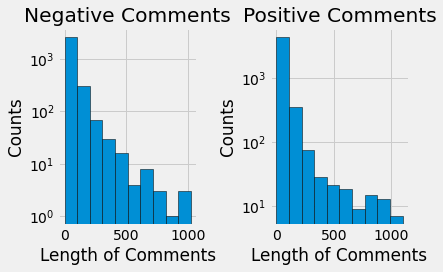

In [7]:
# 关于老师的假想验证

from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')

filt = (df_train['Label'] == 0)
neg_x = df_train.loc[filt,:]['Comments'].map(len)
pos_x = df_train.loc[~filt,:]['Comments'].map(len)


ax1 = plt.subplot(121)
plt.hist(neg_x, edgecolor='black', log=True)
plt.title('Negative Comments')
plt.xlabel('Length of Comments')
plt.ylabel('Counts')

ax2 = plt.subplot(122)
plt.hist(pos_x, edgecolor='black', log=True)
plt.title('Positive Comments')
plt.xlabel('Length of Comments')
plt.ylabel('Counts')

plt.tight_layout()

# 根据图像 我的答案是评论的长度不是一个可以判断情感正负的靠谱的特征
print(f'训练集样本数：{len(train_comments)} \n测试集样本数：{len(test_comments)}')